# Developing Merge Utilities

## Setup

In [26]:
import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import urllib
import datetime
import math
import shapely
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time # Used for progress bar 
import sys # Used for progress bar 

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Warning is raised when creating Point object from coords. Can't figure out why. 

In [27]:
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client('s3') # for lower-level processes

## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"

In [28]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary 
temp_dir = "./tmp"
if not os.path.exists(temp_dir): 
    os.mkdir(temp_dir)

## Define helper functions

In [29]:
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    """
    Print a progress bar to console 

    References
    ----------
    https://stackoverflow.com/questions/3160699/python-progress-bar
    
    """
    count = len(it)
    start = time.time() # time estimate start
    def show(j):
        x = int(size*j/count)
        # time estimate calculation and string
        remaining = ((time.time() - start) / j) * (count - j)        
        mins, sec = divmod(remaining, 60) # limited to minutes
        time_str = f"{int(mins):02}:{sec:03.1f}"
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', file=out, flush=True)
    show(0.1) # avoid div/0 
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [30]:
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".nc",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.nc'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='h5netcdf').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

## Read in county shapefile and station metadata csv

County shapefile is used for getting event geometry
Station metadata is used to get the station ids to read in station data from the S3 bucket

In [31]:
# Read in a list of weather stations 
# We just use the names of the stations to filter 
# Ideally I'd like to see this moved to the AWS bucket 
# train_stns = pd.read_csv('../temp_clean_all_station_list.csv')
train_stns = pd.read_csv('temp_clean_all_station_list.csv')

# Create new geometry column from lat and lon columns 
# This will enable us to filter through the GeoDataFrame using our county geometry
train_stns = gpd.GeoDataFrame(
    train_stns, geometry=gpd.points_from_xy(train_stns.longitude, train_stns.latitude, crs="EPSG:4326")
)
#train_stns.head()

In [32]:
# Read in county shapefiles from S3
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp")
ca_counties = ca_counties.to_crs(train_stns.crs) # Convert to station CRS 
#ca_counties.head()

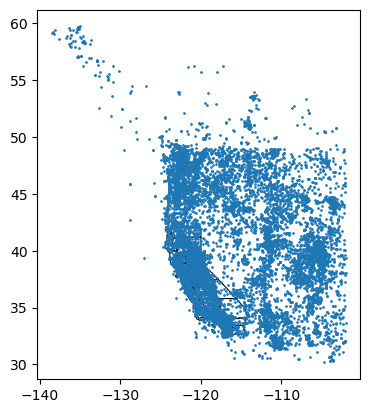

In [33]:
# Plot all the stations and all the counties 
# This is a check to ensure both have the same projection
fig, ax = plt.subplots()
ca_counties.boundary.plot(color="black",ax=ax,linewidth=0.75,zorder=10)
train_stns.geometry.plot(markersize=0.9,ax=ax,zorder=15);

In [34]:
event_start_date = "2018-01-01" # Start a few days before the mudslide
event_end_date = "2018-01-09"

event_geom = ca_counties[ca_counties["NAME"] == "Santa Barbara"] # Get event geometry

train_stns["intersects"] = train_stns.intersects(event_geom.unary_union) # See which stations intersect with the event polygon
event_stns = train_stns[train_stns["intersects"]==True].reset_index(drop=True) # Get just those stations, drop the others 
event_stns

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,cleaned,time_cleaned,network,...,pr_1h_nobs,pr_24h_nobs,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs,geometry,intersects
0,24,ASOSAWOS_72289523243,34.667000,-120.467000,-30479.6952,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 11:28:51+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,298617.0,229358.0,0.0,308933.0,POINT (-120.46700 34.66700),True
1,130,ASOSAWOS_72393093214,34.717000,-120.567000,-30479.6952,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 10:42:22+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,251494.0,207124.0,0.0,256855.0,POINT (-120.56700 34.71700),True
2,291,ASOSAWOS_72376293244,34.607000,-120.076000,204.5208,2006-01-05 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 11:52:07+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,329292.0,198166.0,0.0,333886.0,POINT (-120.07600 34.60700),True
3,312,ASOSAWOS_72394023273,34.894000,-120.452000,74.0664,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 04:15:32+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,452731.0,339254.0,0.0,559784.0,POINT (-120.45200 34.89400),True
4,327,ASOSAWOS_72392523190,34.424000,-119.842000,2.4384,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 04:18:55+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,410307.0,292920.0,0.0,494638.0,POINT (-119.84200 34.42400),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,14394,RAWS_DNTC1,34.009167,-119.654167,800.0000,2001-04-03 00:00:00+00:00,2010-11-10 19:10:00+00:00,Y,2023-02-09 17:59:17+00:00,RAWS,...,0.0,0.0,0.0,79257.0,79246.0,78985.0,0.0,79294.0,POINT (-119.65417 34.00917),True
163,14396,RAWS_TR153,34.445056,-119.626167,372.0000,2001-11-10 00:00:00+00:00,2011-03-30 15:48:00+00:00,Y,2023-02-10 02:19:46+00:00,RAWS,...,0.0,0.0,0.0,28288.0,28283.0,28269.0,0.0,28328.0,POINT (-119.62617 34.44506),True
164,14640,RAWS_FGMC1,34.734428,-120.006561,3183.0000,2002-11-20 00:00:00+00:00,2023-03-07 01:35:00+00:00,Y,2023-02-09 18:39:11+00:00,RAWS,...,0.0,0.0,0.0,168659.0,168614.0,159701.0,168575.0,168825.0,POINT (-120.00656 34.73443),True
165,14768,RAWS_GVTC1,34.488400,-120.235740,878.0000,2018-01-31 22:11:00+00:00,2023-03-07 01:09:00+00:00,Y,2023-02-09 19:24:12+00:00,RAWS,...,0.0,0.0,0.0,40077.0,40077.0,39936.0,40074.0,40082.0,POINT (-120.23574 34.48840),True


## Precipitation Standardization

### load and explore sample precipication data